In [1]:
import os
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button
import matplotlib as mpl

In [2]:
# Preproccess i imagine we can use the watershed algorithm to remove noise?
# Then grabcut for reducing the pixel noise? might be too fuzzy... who knows

# need a failsafe check for Nearest neighbour on flourescent pixels, as binary map COULD remove this by accident

In [9]:
# Hyperparameters 

pixel_jump_limit = 400; # these seem to be stable 
flourescence_color_range = 80;
flouresence_threshold = 170; # 175 seems to be a stable point # DEPRECATED - USING LIGHT RANGE

In [13]:
dummy_path = "../data/dummy/"
real_path = "../data/fspi/"
dummy_files = [f for f in listdir(dummy_path) if isfile(join(dummy_path, f))]
real_files = [f for f in listdir(real_path) if isfile(join(real_path, f))]

looking at IMG_4840.JPG


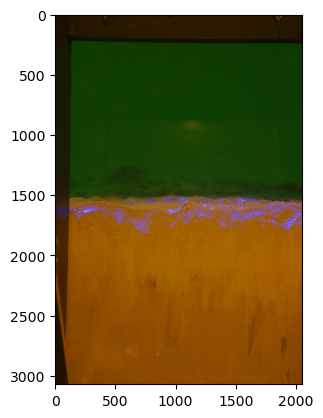

In [14]:
file_num = 1
#print(f"looking at {dummy_files[file_num]}")
#img = cv2.imread(dummy_path + dummy_files[file_num])

print(f"looking at {real_files[file_num]}")
img = cv2.imread(real_path + real_files[file_num])

plt.imshow(img)

159 89 0


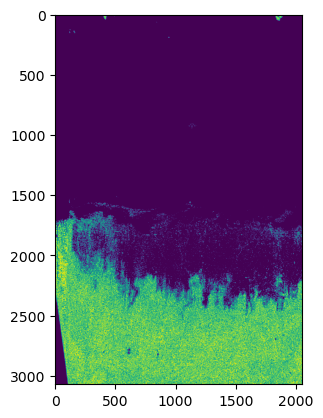

In [15]:
# either we go for a greyscale bit mask or we try something with the colour range... 

tune = 100
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#ret, thresh = cv2.threshold(gray,flouresence_threshold,255,cv2.THRESH_BINARY)

x_high = gray.argmax(axis=0)
y_high = gray.argmax(axis=1)

## OpenCV uses BGR
b_high,g_high,r_high = img[x_high[0],y_high[0]]

b_high = int(b_high)
g_high = int(g_high)
r_high = int(r_high)

print(b_high,g_high,r_high)

thresh = cv2.inRange(img, (b_high-tune, g_high-tune , r_high-tune), (b_high, g_high,r_high))

mask = (thresh > 0)
plt.imshow(mask)

In [28]:
# Heres where i think a handwritten logic is better, lets assume a pixel distance greater than 50 ish is a random 
# jump which we should not allow, keep track of line properties and fill back on backtrack 

In [29]:
# this will return the y position, col index is x position
def first_set_bit(col):
    for idx,bit in enumerate(col):
        if bit == True:
            return idx
    return None

def last_set_bit(col):
    iter = None
    for idx,bit in enumerate(col):
        if bit == True:
            iter = idx;
    return iter

sharp_mask = np.zeros(mask.shape) # draw the boundary to
num_cols = mask.shape[1]

# logic here is that if not found, continue horizontally
prev_y = None
not_written = []
for col_index in range(0,mask.shape[1]):
    col = mask[:, col_index]
    y = first_set_bit(col)
    x = col_index

    ## Fine tuning! 
    if y != None:
        if prev_y != None and abs(y - prev_y) > pixel_jump_limit:
            y = prev_y;
        else:
            prev_y = y;
            
        sharp_mask[y,x] = 1
        if len(not_written) > 0:
            for term in not_written:
                sharp_mask[y,term] = 1
            not_written.clear()
            
    elif prev_y != None:
        sharp_mask[prev_y,x] = 1
        prev_y = prev_y
    else:
        not_written.append(x)

In [30]:
# Univariate Spline algorithm can then connect the points logically

In [ ]:
# Find the column indices of non-zero pixels in each row
non_zero_indices = np.where(sharp_mask > 0)

# Create a set of points (x, y) for the non-zero pixels
points = np.column_stack((non_zero_indices[1], non_zero_indices[0]))

# Sort the points based on x-coordinate
points = points[np.argsort(points[:, 0])]

# Fit a spline through the points

spline = UnivariateSpline(points[:, 0], points[:, 1], k=3, s=1)
#spline = InterpolatedUnivariateSpline(points[:, 0], points[:, 1]) # seems to be much faster?? sometimes?

# Generate a set of x values to evaluate the spline
x_values = np.linspace(points[:, 0].min(), points[:, 0].max(), 1000)

# Evaluate the spline to get corresponding y values
y_values = spline(x_values)

# Round the coordinates and draw the smooth line on the image
smooth_line_coordinates = np.column_stack((np.round(x_values).astype(int), np.round(y_values).astype(int)))

img_copy = img.copy()

cv2.polylines(img_copy, [smooth_line_coordinates], isClosed=False, color=255, thickness=10)
plt.imshow(img_copy)

In [56]:
cv2.imwrite("../test.jpg", img_copy)

True